In [980]:
from util.experiment_setup import load_model
from matplotlib import pyplot as plt
import seaborn as sns
from util.activation_visualization import effective_receptive_field, rescaleZeroOne
from util.plotting import relabel_axis_with_images
from torchvision.transforms import functional as F
import numpy as np
import os.path as osp

In [981]:
model_path = "../models/mod3_weight_reg/1e-4"
model = load_model(model_path)
model = model.get_sequential()
model

Sequential(
  (0): SpaceToDepth()
  (1): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (2): ELU(alpha=1.0, inplace=True)
  (3): SpaceToDepth()
  (4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): ELU(alpha=1.0, inplace=True)
  (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (7): ELU(alpha=1.0, inplace=True)
  (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (9): ELU(alpha=1.0, inplace=True)
  (10): AdaptiveMaxPool2d(output_size=[2, 3])
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=384, out_features=128, bias=True)
  (13): ELU(alpha=1.0, inplace=True)
  (14): Linear(in_features=128, out_features=128, bias=True)
  (15): ELU(alpha=1.0, inplace=True)
  (16): Linear(in_features=128, out_features=10, bias=True)
  (17): Softmax(dim=-1)
)

In [982]:
prev_layer = 1
cur_layer = 4

In [983]:
eff_rfs = effective_receptive_field(model[:prev_layer+2], n_batch=1, fill_value=0.5, device="cuda")
prev_layer_rfs = [F.to_pil_image(rescaleZeroOne(eff_rf)) for eff_rf in eff_rfs]

eff_rfs = effective_receptive_field(model[:cur_layer+2], n_batch=1, fill_value=0.5, device="cuda")
cur_layer_rfs = [F.to_pil_image(rescaleZeroOne(eff_rf)) for eff_rf in eff_rfs]

100%|██████████| 32/32 [00:00<00:00, 413.48it/s]


In [984]:
connectivity_matrix = model[cur_layer].weight.detach().cpu().abs().sum(axis=(-1,-2)).numpy()
spd_factor = int(connectivity_matrix.shape[1]/len(prev_layer_rfs))
connectivity_matrix = connectivity_matrix.reshape(-1,spd_factor).sum(axis=-1).reshape(connectivity_matrix.shape[0],int(connectivity_matrix.shape[1]/spd_factor))

In [985]:
reorder_x = np.argsort(connectivity_matrix.sum(axis=1))[::-1]
reorder_y = np.argsort(connectivity_matrix.sum(axis=0))[::-1]

# reorder_x = np.argsort(connectivity_matrix[:,np.argmax(connectivity_matrix.sum(axis=0))])[::-1]
# reorder_y = np.argsort(connectivity_matrix[np.argmax(connectivity_matrix.sum(axis=1))])[::-1]

# reorder_x = np.argsort(connectivity_matrix.mean(axis=1))[::-1]
# reorder_y = np.argsort(connectivity_matrix.mean(axis=0))[::-1]

In [986]:
reorder_x

array([11,  6,  8,  7,  3, 21, 15, 16, 29, 13, 24, 22, 28, 26,  2, 23,  1,
       17,  9,  0, 27, 10, 25, 30, 18, 19, 20,  4, 31, 14, 12,  5])

In [987]:
import scipy

new_order_x = [reorder_x[0]]
col_cost_matrix = scipy.spatial.distance.cdist(connectivity_matrix,connectivity_matrix)
for i in range(col_cost_matrix.shape[0]):
    cost = col_cost_matrix[new_order_x[-1]]
    min_order = np.argsort(cost)
    for index in min_order:
        if index not in new_order_x:
            new_order_x.append(index)
            break

reorder_x = new_order_x

new_order_y = [reorder_y[0]]
row_cost_matrix = scipy.spatial.distance.cdist(connectivity_matrix.T,connectivity_matrix.T)
for i in range(row_cost_matrix.shape[0]):
    cost = row_cost_matrix[new_order_y[-1]]
    min_order = np.argsort(cost)
    for index in min_order:
        if index not in new_order_y:
            new_order_y.append(index)
            break
reorder_y = new_order_y

In [988]:
sums_y = connectivity_matrix.sum(axis=0)[None,:]
new_mat = np.append(connectivity_matrix, sums_y/sums_y.max() * connectivity_matrix.max(), axis=0)
sums_x = new_mat.sum(axis=1)[:, None]
new_mat = np.append(new_mat, sums_x/sums_x.max() * connectivity_matrix.max(), axis=1)
new_mat[-1,-1]=None
reorder_x = np.append(reorder_x, connectivity_matrix.shape[0])
reorder_y= np.append(reorder_y, connectivity_matrix.shape[1])

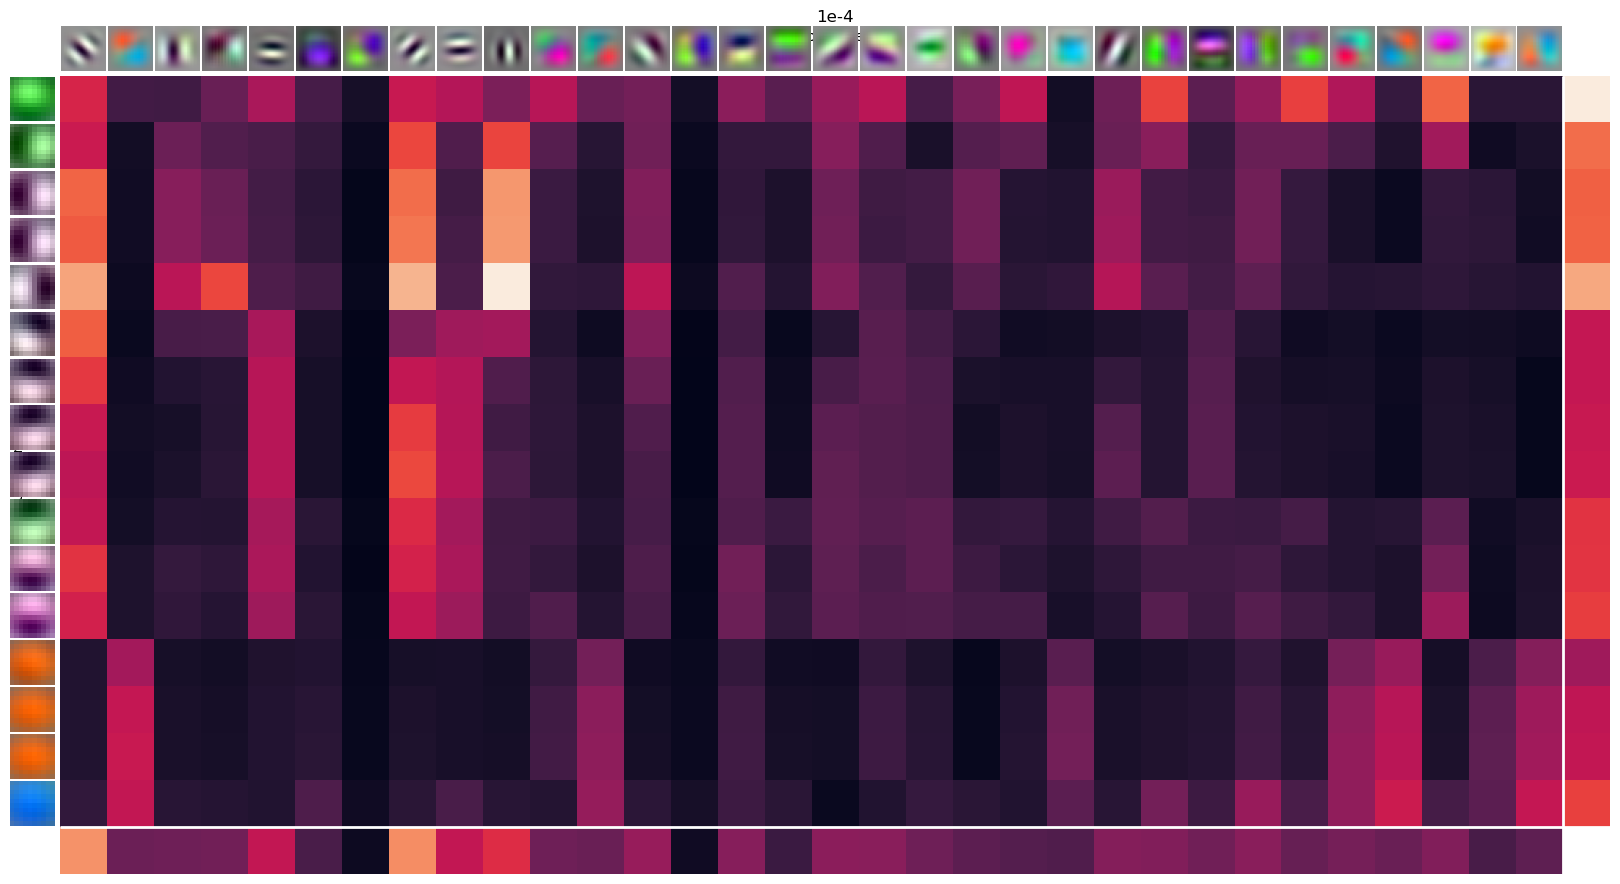

In [989]:
fig = plt.figure(figsize=(20,20))
plt.title(osp.split(model_path)[1])
ax = sns.heatmap(new_mat[reorder_x].T[reorder_y], square=True, xticklabels=[], yticklabels=[], cbar=False, annot=False)
ax.set_ylabel("input layer: " + str(prev_layer), labelpad=25)
ax.xaxis.set_label_position('top')
ax.set_xlabel("output layer: " + str(cur_layer), labelpad=25)
relabel_axis_with_images(fig, ax, np.array(cur_layer_rfs)[reorder_x[:-1]], np.array(prev_layer_rfs)[reorder_y[:-1]], n_x=len(cur_layer_rfs)+1,n_y=len(prev_layer_rfs)+1)
ax.vlines(new_mat.shape[0]-1, 0,new_mat.shape[1], colors="white", linewidth=2)
ax.hlines(new_mat.shape[1]-1, 0,new_mat.shape[0], colors="white", linewidth=2)
plt.show()